In [1]:
from pandas_datareader import data as pdr
import FinanceDataReader as fdr
import yfinance as yf
from pykrx import stock
from datetime import datetime, timedelta
import pandas as pd
import numpy as np
import math     
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings(action='ignore')

from matplotlib import font_manager, rc
font_name = font_manager.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name()
rc('font', family=font_name)
plt.rcParams['axes.unicode_minus'] = False

# 함수

In [2]:
def myplot(df, nrows=5,  kind='line', title='제목', labels=False):  
#     if nrows > 0:
#         print(df.head(nrows))
#     else:
#         print(df.tail(nrows))
    if labels:
        cols = df.columns
        for i, col in enumerate(cols):
            df[col].plot(label=labels[i], kind=kind)
    else :
        df.plot(kind=kind)
    
    plt.title(title)
    plt.legend()
    plt.show()


In [3]:
def myplotmix(df1, df2, y1='ylabel-1', y2='ylabel-2', kind1='bar', kind2='line', title='제목',  nrows1=5, nrows2=5,  labels=False):  
    ytl=['b', 'g', 'r', 'c', 'm', 'y', 'k', 'w']

    if nrows1 > 0:
        print(df1.head(nrows1))
    elif nrows1 < 0:
        print(df1.tail(nrows1))
    if nrows2 > 0:
        print(df2.head(nrows2))
    else:
        print(df2.tail(nrows2))
    fig, ax1 = plt.subplots(figsize=(12, 4))
    ax2=ax1.twinx()
    if kind1 == 'line':
        df1.plot(kind=kind1, ax=ax2, marker='d',color='#e35f62')  #color='y', 
        df2.plot(kind=kind2, ax=ax1)  #bar
    else:
        df1.plot(kind=kind1, ax=ax1,color='#bcbd22')
        df2.plot(kind=kind2, ax=ax2) #color='y',
        
    # df['date'] = df['date'].dt.strftime('%Y-%m-%d') 
    # ax1.set_xticklabels(df['date'])    
    ax1.yaxis.tick_right()
    ax2.yaxis.tick_left()
    ax1.set_ylabel(y1) #, color='red')
    ax2.set_ylabel(y2) #, color='red')
    ax1.legend(loc=1)
    ax2.legend(loc=2)
    plt.title(title)
    ax1.grid(False)
    
    plt.show()

- 옵션가 계산 수식

In [4]:
def 잔존만기(오늘날짜, 만기일, workday=252):
    오늘날짜 = pd.to_datetime(오늘날짜).date()
    만기일 = pd.to_datetime(만기일).date()
    잔존만기일 = (np.busday_count(오늘날짜, 만기일)+1)/workday
    return 잔존만기일

In [5]:
def 옵션가(선물지수, 이자율, 배당률, 오늘, 만기일):
    선물이론가 = 선물지수 * np.exp((이자율-배당률) * np.busday_count(오늘, 만기일)/252)
    return 선물이론가

## 블랙숄즈 방정식
기초자산, 행사가, 잔존만기일, 이자율=0.025, 변동성=30%

In [6]:
# 블랙숄즈 방정식
def 옵션이론가(기초자산, 행사가, 잔존만기일, 이자율=0.02, 변동율=0.4):
    d1 = (np.log(기초자산/행사가) + (이자율 + (변동율**2)*0.5)*잔존만기일) / (변동율* np.sqrt(잔존만기일))
    d2 = d1 - (변동율 * np.sqrt(잔존만기일))
    옵션이론가 = 기초자산 * stats.norm.cdf(d1,0.0,1.0) - 행사가 * np.exp(-이자율*잔존만기일)*stats.norm.cdf(d2,0.0,1.0)
#     print(f'd1={d1},d2={d2}')
    return 옵션이론가

In [7]:
# # 강사님 코드 - 3차원 그래프
# delta = mydelta(기초자산S, 행사가K, 잔존만기일)
# # print(delta)
# delta = np.array(delta).reshape(-1,1)
# plt.figure(figsize = (5,3.5))
# ax = plt.subplot(1,1,1,projection = '3d')
# ax.plot_surface(기초자산S,행사가K,delta,rstride = 1,cstride = 1,alpha = 0.3,color = 'blue',edgecolor = 'black')
# ax.set_xlabel('기초자산S')
# ax.set_ylabel('행사가K')
# ax.set_zlabel('delta')
# plt.show()

In [8]:
오늘 = '2018-07-01'
만기일 = '2019-03-21'
현물가 = 300
행사가 = 330
잔존만기일 = 잔존만기(오늘, 만기일)
옵션가 = 옵션이론가(현물가,행사가,잔존만기일)
print(f'잔존만기일 = {잔존만기일}')
print(f'옵션이론가 = {옵션가}')


잔존만기일 = 0.75
옵션이론가 = 31.5719274484114


## 기초자산 & 행사가

In [9]:
sdic = []
deldic = []
기초자산S = np.arange(200,400, 10)  #기초자산==현물가격
행사가K = np.arange(155,355, 10)  #행사가
잔존만기일 = 0.38492

kdic = {}
for k in 행사가K:
    sdic = {}
    for s in 기초자산S:
        옵션가 = 옵션이론가(s,k,잔존만기일)
        sdic[s] = 옵션가
    kdic[f'KOSPI KE{k}'] = pd.Series(sdic)
df = pd.DataFrame(kdic)
df.head()

KOSPI KE155  KOSPI KE165  KOSPI KE175  KOSPI KE185  KOSPI KE195  \
200    49.415107    41.580818    34.509187    28.259514    22.848014   
210    58.411048    50.060408    42.364469    35.407438    29.237507   
220    67.704733    58.947219    50.735917    43.168766    36.316911   
230    77.214370    68.143655    59.517632    51.438501    43.991264   
240    86.877740    77.570681    68.618131    60.119418    52.165382   

     KOSPI KE205  KOSPI KE215  KOSPI KE225  KOSPI KE235  KOSPI KE245  \
200    18.251978    14.418091    11.272407     8.729984     6.702965   
210    23.865731    19.269905    15.401564    12.194220     9.571346   
220    30.219595    24.883889    20.288246    16.388422    13.124336   
230    37.236182    31.205243    25.902432    21.306948    17.378243   
240    44.829870    38.164051    32.194003    26.921310    22.325966   

     KOSPI KE255  KOSPI KE265  KOSPI KE275  KOSPI KE285  KOSPI KE295  \
200     5.106595     3.863157     2.904117     2.170895     1.614680   
210     7.453185     5.761949     4.425369     3.378774     2.566002   
220    10.426744     8.223008     6.441605     5.015307     3.883167   
230    14.061781    11.294655     9.010505     7.143438     5.630882   
240    18.370676    15.005730    12.173763     9.813973     7.865535   

     KOSPI KE305  KOSPI KE315  KOSPI KE325  KOSPI KE335  KOSPI KE345  
200     1.195654     0.881910     0.648261     0.475088     0.347271  
210     1.939473     1.459694     1.094451     0.817854     0.609360  
220     2.991506     2.294162     1.752219     1.333423     1.011426  
230     4.415442     3.445926     2.677717     2.072670     1.598712  
240     6.270157     4.973815     3.927767     3.089017     2.420338

<AxesSubplot:>

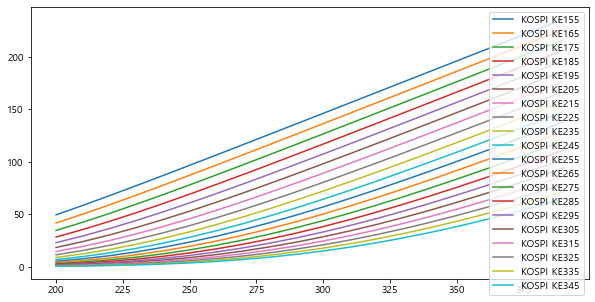

In [10]:
df.plot(figsize=(10,5))

행사가가 낮으면 낮을수록 콜옵션이 가격이 올라간다 -> 이윤을 남기려고 권리를 행사할 가능성이 커진다

## Greek : 옵션민감도(영향을 주는 정도)
블랙숄즈
 - 기초자산 S, 행사가격 X, 무위험수익률 r, 잔존기간 t, 기초자산변동성 델타
 - 행사가 X 제외 나머지는 변화하는 값
 - 기초자산, 이자율, 변동성은 예측 불가 -> 변화에 따른 옵션의 민감도를 나타낼 지표

In [15]:
def Greek_Delta(현물가, 행사가, 잔존만기일, 이자율=0.02, 변동율=0.4):
    d1 = (np.log(현물가/행사가) + (이자율 + (변동율**2)*0.5)*잔존만기일) / (변동율* np.sqrt(잔존만기일))
    delta = stats.norm.cdf(d1,0.0,1.0)
    return delta

In [34]:
def Greek_gamma(현물가, 행사가, 잔존만기일, 이자율=0.02, 변동율=0.4):
    d1 = (np.log(현물가/행사가) + (이자율 + (변동율**2)*0.5)*잔존만기일) / (변동율* np.sqrt(잔존만기일))
    gamma = ( np.exp(-1*(d1**2)*0.5)/ np.sqrt(2* math.pi )) / (현물가*변동율*np.sqrt(잔존만기일) )
    return gamma

In [44]:
def Greek_Theta(현물가, 행사가, 잔존만기일, 이자율=0.02, 변동율=0.4):
    d1 = (np.log(현물가/행사가) + (이자율 + (변동율**2)*0.5)*잔존만기일) / (변동율* np.sqrt(잔존만기일))
    d2 = d1 - (변동율 * np.sqrt(잔존만기일))    
    theta =  -( 현물가 * ( np.exp(-(d1**2)*0.5) / np.sqrt(2 * math.pi) ) * 변동율 ) / ( 2 * np.sqrt(잔존만기일)) - 이자율 * 행사가 * np.exp( -이자율 * 잔존만기일 ) * stats.norm.cdf(d2,0.0,1.0)
    return theta

In [43]:
np.sqrt(2*math.pi)

2.5066282746310002

In [39]:
def Greek(현물가, 행사가, 잔존만기일, 이자율=0.02, 변동율=0.4):
    d1 = (np.log(현물가/행사가) + (이자율 + (변동율**2)*0.5)*잔존만기일) / (변동율* np.sqrt(잔존만기일))
    d2 = d1 - (변동율 * np.sqrt(잔존만기일))    
    delta = stats.norm.cdf(d1,0.0,1.0)
    gamma = ( np.exp(-1*(d1**2)*0.5)/ np.sqrt(2* math.pi )) / (현물가*변동율*np.sqrt(잔존만기일) )
    theta =  -1*( 현물가 * ( np.exp(-(d1**2)*0.5) / np.sqrt(2 * math.pi) ) * 변동율 ) / ( 2 * np.sqrt(잔존만기)) - 이자율 * 행사가 * np.exp( -이자율 * 잔존만기 ) * stats.norm.cdf(d2,0.0,1.0)
    return delta#,gamma,theta

## 델타, 감마 : 기초자산 & 행사가의 영향도 분석
<pre>
기초자산가격의 한단위 변동에 대한 옵션가의 가격 변화
delta = 

In [20]:
# for s in df.index:
#     for k in 행사가K:
# #     for s in 기초자산S:
#         df[f'delta({k})'] = Greek_Delta(s, k, 잔존만기일)
# df

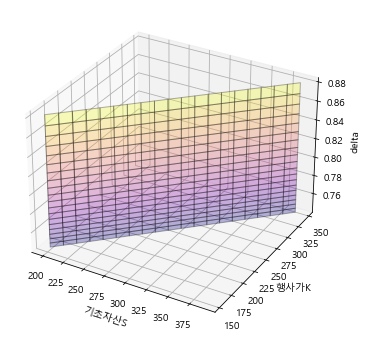

In [30]:
delta = Greek_Delta(기초자산S, 행사가K, 잔존만기일)
delta = np.array(delta).reshape(-1,1)
temp = pd.DataFrame(delta, columns=['delta'])
temp['기초자산S'] = pd.DataFrame(np.array(기초자산S).reshape(-1,1))
temp['행사가K'] = pd.DataFrame(np.array(행사가K).reshape(-1,1))



plt.figure(figsize = (8,6))
ax = plt.subplot(1,1,1,projection = '3d')
ax.plot_surface(기초자산S,행사가K, delta, rstride = 1,cstride = 1,alpha = 0.3,edgecolor = 'black',cmap='plasma')
ax.set_xlabel('기초자산S')
ax.set_ylabel('행사가K')
ax.set_zlabel('delta')
# ax.view_init(35,65) 
plt.show()

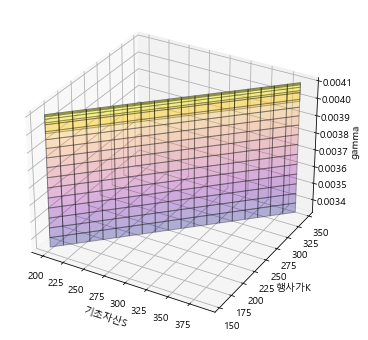

In [36]:
gamma = Greek_gamma(기초자산S, 행사가K, 잔존만기일)
gamma = np.array(gamma).reshape(-1,1)
temp_gamma = pd.DataFrame(gamma, columns=['gamma'])
temp_gamma['기초자산S'] = pd.DataFrame(np.array(기초자산S).reshape(-1,1))
temp_gamma['행사가K'] = pd.DataFrame(np.array(행사가K).reshape(-1,1))



plt.figure(figsize = (8,6))
ax = plt.subplot(1,1,1,projection = '3d')
ax.plot_surface(기초자산S,행사가K, gamma, rstride = 1,cstride = 1,alpha = 0.3,edgecolor = 'black',cmap='plasma')
ax.set_xlabel('기초자산S')
ax.set_ylabel('행사가K')
ax.set_zlabel('gamma')
# ax.view_init(35,65) 
plt.show()

theta = Greek_Theta(기초자산S, 행사가K, 잔존만기일)
theta = np.array(theta).reshape(-1,1)
temp_theta = pd.DataFrame(theta, columns=['theta'])
temp_theta['기초자산S'] = pd.DataFrame(np.array(기초자산S).reshape(-1,1))
temp_theta['행사가K'] = pd.DataFrame(np.array(행사가K).reshape(-1,1))


plt.figure(figsize = (8,6))
ax = plt.subplot(1,1,1,projection = '3d')
ax.plot_surface(기초자산S,행사가K, theta, rstride = 1,cstride = 1,alpha = 0.3,edgecolor = 'black',cmap='plasma')
ax.set_xlabel('기초자산S')
ax.set_ylabel('행사가K')
ax.set_zlabel('theta')
# ax.view_init(35,65) 
plt.show()

In [55]:
# 행사가K = 250
# 기초자산S = np.arange(200,400, 10)
# for s in 기초자산S:
#     print(s,np.log(s/k))
    
# # 기초자산 고정, 행사가 커질수록 값 작아짐
# # 기초자산 < 행사가 -> 델타 마이너스

200 -0.6678293725756556
210 -0.6190392084062235
220 -0.5725191927713306
230 -0.5280674302004967
240 -0.48550781578170077
250 -0.44468582126144557
260 -0.40546510810816444
270 -0.3677247801253174
280 -0.3313571359544425
290 -0.2962658161431724
300 -0.262364264467491
310 -0.22957444164450025
320 -0.19782574332991992
330 -0.1670540846631662
340 -0.137201121513485
350 -0.10821358464023272
360 -0.08004270767353637
370 -0.05264373348542203
380 -0.025975486403260677
390 0.0


In [ ]:
# 